In [159]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin


import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import numpy as np
import os
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

## Retrieving and splitting data 

In [111]:
df = pd.read_csv('training_dataset.csv')
X = df.loc[:, 'rms_mean':]
y = df['classID']

folds = [(df.loc[df['fold'] != i].index, df.loc[df['fold'] == i].index) for i in range(1, 11)]

##  Some PCA

In [112]:
std_sc = StandardScaler()
pca_2 = PCA(n_components = 0.9)

X_tr = std_sc.fit_transform(X)
X_tr_pca = pca_2.fit_transform(X_tr)

In [123]:
exp_var = pca_2.explained_variance_ratio_
exp_var

array([0.33918803, 0.12317018, 0.09532814, 0.0830461 , 0.06767311,
       0.03371203, 0.03343044, 0.03273635, 0.0324358 , 0.02906265,
       0.028131  , 0.02260343])

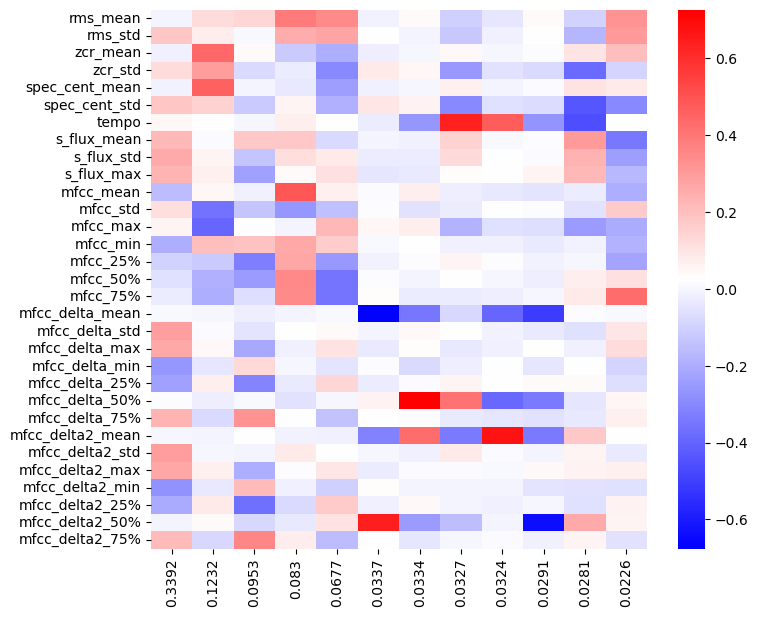

In [151]:
fig, ax = plt.subplots(figsize = (8, 7))
sns.heatmap(pca_2.components_.T, cmap ='bwr', annot = False, ax = ax,
            yticklabels = X.columns, xticklabels = np.round(exp_var, 4));

In [101]:
class CustomLogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_one=True):
        self.add_one = add_one

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        if self.add_one:
            # Add 1 to avoid log(0) errors
            X_transformed = np.log(X + 1)
        else:
            # Handle case where values allow direct log transformation
            X_transformed = np.log(X)
        return X_transformed

In [161]:
df.columns

Index(['slice_file_name', 'classID', 'fold', 'rms_mean', 'rms_std', 'zcr_mean',
       'zcr_std', 'spec_cent_mean', 'spec_cent_std', 'tempo', 's_flux_mean',
       's_flux_std', 's_flux_max', 'mfcc_mean', 'mfcc_std', 'mfcc_max',
       'mfcc_min', 'mfcc_25%', 'mfcc_50%', 'mfcc_75%', 'mfcc_delta_mean',
       'mfcc_delta_std', 'mfcc_delta_max', 'mfcc_delta_min', 'mfcc_delta_25%',
       'mfcc_delta_50%', 'mfcc_delta_75%', 'mfcc_delta2_mean',
       'mfcc_delta2_std', 'mfcc_delta2_max', 'mfcc_delta2_min',
       'mfcc_delta2_25%', 'mfcc_delta2_50%', 'mfcc_delta2_75%'],
      dtype='object')

## Logistic Regression

### With log transformations

In [106]:
log_features = ['rms_mean', 'rms_std', 'zcr_mean', 'zcr_std', 'spec_cent_std',
            's_flux_std', 's_flux_max', 'mfcc_delta_max', 'mfcc_delta_std', 
            'mfcc_delta_75%', 'mfcc_delta2_std', 'mfcc_delta2_max', 'mfcc_delta2_75%']

preprocessor = ColumnTransformer(transformers = [
    ('log', CustomLogTransformer(), log_features),
    ('ss', StandardScaler(), X.columns)
])

# Create the pipeline
pipeline = Pipeline(steps= [
    ('pp', preprocessor),
    ('model', LogisticRegression())
    ]
)

param_grid = {
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__C': [1e-3, 1e-1, 1, 10, 100],
    'model__solver': ['lbfgs', 'saga']
}

logreg_log = GridSearchCV(pipeline, param_grid = param_grid, cv = folds, scoring = 'accuracy')

logreg_log.fit(X, y)
print(f"Best: {logreg_log.best_score_} using {logreg_log.best_params_}")

Best: 0.6049195057004811 using {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'saga'}


### Without log transformations 

In [47]:
preprocessor = ColumnTransformer(transformers = [
    ('ss', StandardScaler(), X.columns)
])

# Create the pipeline
pipeline = Pipeline(steps= [
    ('pp', preprocessor),
    ('model', LogisticRegression())
    ]
)

param_grid = {
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__C': [1e-3, 1e-1, 1, 10, 100],
    'model__solver': ['lbfgs', 'saga']
}

logreg = GridSearchCV(pipeline, param_grid = param_grid, cv = folds, scoring = 'accuracy')

logreg.fit(X, y)
print(f"Best: {logreg.best_score_} using {logreg.best_params_}")

Best: 0.6066350847387061 using {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


## XGBoost

In [152]:
preprocessor = ColumnTransformer(transformers = [
    ('ss', StandardScaler(), X.columns)
])

# Create the pipeline
pipeline = Pipeline(steps= [
    ('pp', preprocessor),
    ('model', XGBClassifier())
    ]
)

param_grid = {
    'model__eta': [0.01, 0.1, 0.3],
    'model__max_depth': [2, 6, 10],
    'model__n_estimators': [100, 300, 500]
}

gs = GridSearchCV(pipeline, param_grid = param_grid, cv = folds, scoring = 'accuracy')

gs.fit(X, y)
print(f"Best: {gs.best_score_} using {gs.best_params_}")

Best: 0.6332668900378668 using {'model__eta': 0.3, 'model__max_depth': 6, 'model__n_estimators': 500}


In [154]:
scores = gs.cv_results_['mean_test_score']

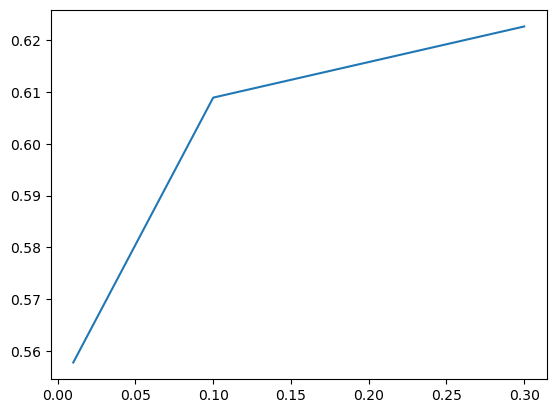

In [155]:
learning_rates = gs.cv_results_['param_model__eta']

sc_lr = {}
for sc, lr in zip(scores, learning_rates):
    if lr not in sc_lr:
        sc_lr[lr] = [[sc], sc]
    else:
        sc_lr[lr][0].append(sc)
        sc_lr[lr][1] = np.mean(sc_lr[lr][0])

sns.lineplot(x = sc_lr.keys(), y = [mean[1] for mean in sc_lr.values()]);

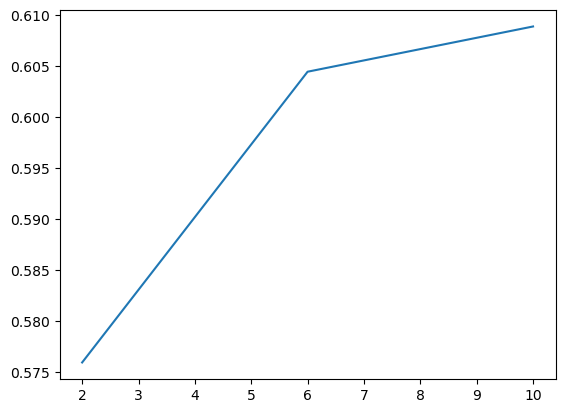

In [156]:
max_depth_list = gs.cv_results_['param_model__max_depth']

max_depth = {}
for sc, md in zip(scores, max_depth_list):
    if md not in max_depth:
        max_depth[md] = [[sc], sc]
    else:
        max_depth[md][0].append(sc)
        max_depth[md][1] = np.mean(max_depth[md][0])

sns.lineplot(x = max_depth.keys(), y = [mean[1] for mean in max_depth.values()]);

In [28]:
n_estimators_list

masked_array(data=[300, 500, 100],
             mask=[False, False, False],
       fill_value='?',
            dtype=object)

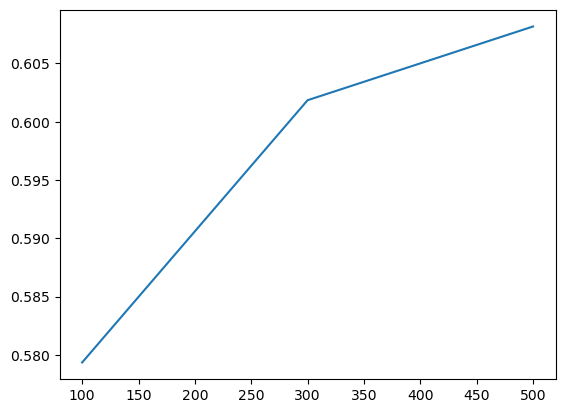

In [157]:
n_estimators_list = gs.cv_results_['param_model__n_estimators']

n_estimators = {}
for sc, ne in zip(scores, n_estimators_list):
    if ne not in n_estimators:
        n_estimators[ne] = [[sc], sc]
    else:
        n_estimators[ne][0].append(sc)
        n_estimators[ne][1] = np.mean(n_estimators[ne][0])

sns.lineplot(x = n_estimators.keys(), y = [mean[1] for mean in n_estimators.values()]);

## CNN

In [3]:
def get_audio_files(path:str):
    counter = 0
    files = []
    
    for file in os.listdir(path):
        if os.path.isdir(f"{path}/{file}"):
            files.extend(get_audio_files(f"{path}/{file}"))
        else:
            title, ext = os.path.splitext(f"{path}/{file}")
            if ext == '.wav':
                files.append(title + ext)
                counter += 1
    return files
    
        

audio_paths = get_audio_files('data')

In [100]:
audio_paths[0]

'data/fold2/203929-7-5-1.wav'

In [4]:
def get_mel_sgrams(files:list):
    mel_sgrams = {}
    for file in files:
        samples, sample_rate = librosa.load(file)
        sgram = librosa.stft(samples)
        sgram_mag, _ = librosa.magphase(sgram)
        mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        mel_sgrams[file] = mel_sgram
    return mel_sgrams

In [5]:
mel_sgrams = get_mel_sgrams(audio_paths)

In [6]:
mel_sgrams['data/fold2/203929-7-5-1.wav'].shape

(128, 173)

In [7]:
#gets max number of columns in the spectrogram
max_length = 0

for i, sgram in enumerate(mel_sgrams.values()):
    if sgram.shape[1] > max_length:
        max_length = sgram.shape[1]
print(f"Max length of mel-spectrograms: {max_length}")

Max length of mel-spectrograms: 174


### Zero-padded spectrograms

Audio files have different durations, therefore the dimensions of the spectrograms are gonna be different. They need to be zero-padded, so the dimensions match and can be used in the CNN

In [8]:
def zero_pad_spectrogram(spectrogram, max_length):

    current_length = spectrogram.shape[1]
    padding = max_length - current_length

  # Creates a zero padding array
    padding_array = np.zeros((spectrogram.shape[0], padding))

  # Stack the spectrogram and padding array horizontally
    padded_spectrogram = np.hstack((spectrogram, padding_array))

    return padded_spectrogram


Structure of zero padded dictionary:

    N-fold

    |

    v

[Train], [Validation]

    |

    V

[X_train, X_val], [y_train, y_val]

In [91]:

zero_padded = {i: [[[], []], [[], []]] for i in range(1, 11)}

for path, sgram in mel_sgrams.items():
    zero_pad = zero_pad_spectrogram(sgram, max_length)
    file_name = path.split('/')[-1]
    target = df.loc[df['slice_file_name'] == file_name, 'classID'].values[0]
    fold = df.loc[df['slice_file_name'] == file_name, 'fold'].values[0]
    zero_padded[fold][1][0].append(zero_pad)
    zero_padded[fold][1][1].append(target)
    for i in range(1, 11):
        if i != fold:
            zero_padded[i][0][0].append(zero_pad)
            zero_padded[i][0][1].append(target)
    

In [93]:
#One hot encode the targets
ohe = OneHotEncoder(sparse_output = False)
for fold in zero_padded.values():
    fold[0][1] = ohe.fit_transform(np.array(fold[0][1]).reshape(-1, 1))
    fold[1][1] = ohe.fit_transform(np.array(fold[1][1]).reshape(-1, 1))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [96]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Convolutional layers with ReLU activation and MaxPooling
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten for dense layers
    x = Flatten()(x)

    # Dense layers with ReLU activation and dropout for regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer with softmax activation for multi-class classification
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    return model

# Define model input shape based on spectrograms
input_shape = (128, 174, 1) 

# Number of targets
num_classes = 10

# Build the CNN model
model = build_cnn_model(input_shape, num_classes)

loss = []
accuracy = []
# Train model cross-validating pre-determined folds
for fold in range(1, 11):

    x_train = np.array(zero_padded[fold][0][0])
    y_train = zero_padded[fold][0][1]
    x_test = np.array(zero_padded[fold][1][0])
    y_test = zero_padded[fold][1][1]
    model.fit(x_train, y_train, epochs=10)

    # Evaluate the fold
    test_loss, test_acc = model.evaluate(x_test, y_test)
    
    loss.append(test_loss)
    accuracy.append(test_acc)
    
    print('Test accuracy:', test_acc)

Epoch 1/10


2024-02-14 17:14:48.080462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - 25s 92ms/step - loss: 27.6703 - accuracy: 0.1248
Epoch 2/10
246/246 [==============================] - 22s 89ms/step - loss: 6.2359 - accuracy: 0.1398
Epoch 3/10
246/246 [==============================] - 22s 89ms/step - loss: 6.0773 - accuracy: 0.1359
Epoch 4/10
246/246 [==============================] - 22s 89ms/step - loss: 3.9986 - accuracy: 0.1504
Epoch 5/10
246/246 [==============================] - 22s 88ms/step - loss: 4.4076 - accuracy: 0.1527
Epoch 6/10
246/246 [==============================] - 22s 90ms/step - loss: 3.2196 - accuracy: 0.1573
Epoch 7/10
246/246 [==============================] - 22s 89ms/step - loss: 3.1047 - accuracy: 0.1512
Epoch 8/10
246/246 [==============================] - 22s 88ms/step - loss: 3.1416 - accuracy: 0.1584
Epoch 9/10
246/246 [==============================] - 22s 91ms/step - loss: 2.5949 - accuracy: 0.1608
Epoch 10/10
 3/28 [==>...........................] - ETA: 1s - loss: 3.0231 - accuracy: 0.15

2024-02-14 17:18:30.303184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 2s 42ms/step - loss: 2.9480 - accuracy: 0.1810
Test accuracy: 0.18098512291908264
Epoch 1/10
246/246 [==============================] - 23s 91ms/step - loss: 3.1932 - accuracy: 0.1536
Epoch 2/10
246/246 [==============================] - 22s 89ms/step - loss: 28.4665 - accuracy: 0.1594
Epoch 3/10
246/246 [==============================] - 22s 88ms/step - loss: 32.3602 - accuracy: 0.1568
Epoch 4/10
246/246 [==============================] - 22s 89ms/step - loss: 9.0978 - accuracy: 0.1653
Epoch 5/10
246/246 [==============================] - 22s 88ms/step - loss: 5.1784 - accuracy: 0.1820
Epoch 6/10
246/246 [==============================] - 22s 88ms/step - loss: 5.5697 - accuracy: 0.1827
Epoch 7/10
246/246 [==============================] - 22s 88ms/step - loss: 5.9153 - accuracy: 0.1968
Epoch 8/10
246/246 [==============================] - 22s 88ms/step - loss: 8.6466 - accuracy: 0.1948
Epoch 9/10
246/246 [==============================] - 22s 8

26/26 [==============================] - 1s 36ms/step - loss: 490513.9062 - accuracy: 0.5236
Test accuracy: 0.5235732197761536
Epoch 1/10
248/248 [==============================] - 23s 92ms/step - loss: 753047.5625 - accuracy: 0.4291
Epoch 2/10
248/248 [==============================] - 23s 91ms/step - loss: 914281.5625 - accuracy: 0.4210
Epoch 3/10
248/248 [==============================] - 23s 94ms/step - loss: 929320.8125 - accuracy: 0.4193
Epoch 4/10
248/248 [==============================] - 22s 89ms/step - loss: 969304.3750 - accuracy: 0.4248
Epoch 5/10
248/248 [==============================] - 22s 90ms/step - loss: 1159137.3750 - accuracy: 0.4117
Epoch 6/10
248/248 [==============================] - 22s 90ms/step - loss: 1176777.6250 - accuracy: 0.4120
Epoch 7/10
248/248 [==============================] - 22s 90ms/step - loss: 1377328.7500 - accuracy: 0.4204
Epoch 8/10
248/248 [==============================] - 23s 91ms/step - loss: 1667529.1250 - accuracy: 0.4010
Epoch 9/10
24

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical


sequence_length = 4  # Adjust based on your audio clip length
num_features = 128  # Replace with actual number of features extracted
num_classes = 6  # Adjust based on the number of sound classes

# Create input layer
inputs = Input(shape=(sequence_length, num_features))

# TimeDistributed LSTM layer
lstm = TimeDistributed(LSTM(units=128, return_sequences=True))(inputs)

# Flatten layer
flattened = Flatten()(lstm)

# Dense output layer
outputs = Dense(num_classes, activation="softmax")(flattened)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Prepare data
# Replace with your data loading and preprocessing logic
# Ensure data is preprocessed into sequences of shape (sequence_length, num_features)
# and labels are one-hot encoded using to_categorical function

# Train the model
model.fit(x_train, y_train_onehot, epochs=10, validation_data=(x_val, y_val_onehot))

# Evaluate the model
model.evaluate(x_test, y_test_onehot)

# Save the model
model.save("urban_sound_classifier.h5")
